# Imports

In [ ]:
!pip install tensorflow==1.15.3
!pip install q Keras==2.2.5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
from google.colab.patches import cv2_imshow
from random import shuffle
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow.contrib.keras as keras

from keras.models import Sequential, Model, load_model
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

from datetime import datetime
import cv2
import tensorflow as tf

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv 


tf.logging.set_verbosity(tf.logging.ERROR)

# Configurations

## Mount Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Constants

In [ ]:
IMG_SIZE = 150
PROJECT_DIR = '/content/drive/MyDrive/Neural_Project/'
os.chdir(PROJECT_DIR)

DATA_PATH = os.path.join("Data (npy)")
date_time = datetime.now().strftime("(%Y/%m/%d, %H:%M)")

MODEL_NAME = "Inception-ResNet_V2"
EPOCHS_NUM = 10
log_dir = f"logs/{MODEL_NAME}({EPOCHS_NUM})-{date_time}"

train_image_path = os.path.join(DATA_PATH, 'train_image - (150-RGB).npy')
test_image_path = os.path.join(DATA_PATH, 'test_image - (150-RGB).npy')

MODEL_FOLDER = 'Inception_ResNet_V2'
MODEL_PATH = os.path.join('Models', f'{MODEL_FOLDER}',f'{MODEL_NAME}_{date_time}_({EPOCHS_NUM}_epoch).model')

# Prepare Data

## Create Train Data

In [ ]:
def create_train_data():
  train_image = []

  for c in Classes['Image']:
    path = os.path.join('Scenes_training_set',c)   # path to building,forest,... folders , c = building,forest,..
    class_label = list(Classes['Image']).index(c)     # class_label = 0, 1, 2, 3, 4

    for img in tqdm(os.listdir(path)):
      img_data = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
      img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)                  # Make it RGB 
      #img_data = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # Read Image and convert it to GRAY
      img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))   # resize image

      train_image.append([np.array(img_data),class_label])

  shuffle(train_image)
  np.save(train_image_path, train_image)

  return train_image

## Create Test Data

In [ ]:
def create_test_data():
  test_image = []
  path = os.path.join('Scenes_testing_set')   # path to testing folder

  for img in tqdm(os.listdir(path)):
    img_data = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)                  # Make it RGB 
    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))   # resize image
    
    test_image.append([np.array(img_data), img])

  np.save(test_image_path, test_image)

  return test_image

# MAIN

Reading CSV file

In [ ]:
Classes = pd.read_csv('names.csv')   

## Pre-Processing

### Train dataset created OR not

In [ ]:
# If Train dataset created or not

if (os.path.exists(train_image_path)):
  train_image = np.load(train_image_path, allow_pickle=True)
  print('Train dataset exist')
else:
  train_image = create_train_data()


Train dataset exist


### Test dataset created OR not

In [ ]:
# If Test dataset created or not

if (os.path.exists(test_image_path)):
  test_image = np.load(test_image_path, allow_pickle=True)
  print('Test dataset exist')
else:
  test_image = create_test_data()
  

Test dataset exist


### Prepare X,Y

In [ ]:
X = np.array([i[0] for i in train_image]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = [i[1] for i in train_image]

# One Hot Encode Y
Y = to_categorical(Y)

# Normalization X 
X = X.astype('float32') / 255

# split train and test
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, shuffle=True)

## Train

### Finetuning

In [ ]:

# load pre-train model to start fine-tune, just run at first time
'''
pretrain_checkpoint_path = os.path.join('Models', f'{MODEL_FOLDER}','Pre-train_Inception-ResNetV2_epoch:10_acc:0.8713.h5')
model = load_model(pretrain_checkpoint_path)
'''

In [ ]:
# load fine-tune to continue training if need
pretrain_checkpoint_path = os.path.join('Models', f'{MODEL_FOLDER}','Fine-Tune_Inception-ResNetV2_epoch:02_acc:0.8896.h5')
model = load_model(pretrain_checkpoint_path)

Freeze layers 

In [ ]:
# Freeze the first ~618 layers (an hyperparameter to be tuned) and ‘unfreeze’ the rest of the layers (last block) to perform fine-tuning

for layer in model.layers[:618]: 
  layer.trainable = False 

for layer in model.layers[618:]: 
  layer.trainable = True

**Training**

In [ ]:
# Recompile the model for these modifications to take effect, use Adam with a low learning rate

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpoint for fine-Tune model

fineTune_checkpoint_path = os.path.join('Models', f'{MODEL_FOLDER}','Fine-Tune_Inception-ResNetV2_epoch:{epoch:02d}_acc:{val_acc:.4f}.h5')
fineTune_checkpoint = ModelCheckpoint(fineTune_checkpoint_path, monitor= 'val_acc', mode= 'max', save_best_only= True, verbose=1)

In [ ]:
model.fit(X_train, Y_train, batch_size=128, epochs=15, validation_data=(X_val, Y_val), callbacks=[fineTune_checkpoint])

## Set X_test and predict

(3050, 2)
3050
3050
buildings
5.jpg


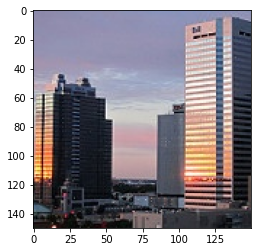

In [ ]:
'''
print(test_image.shape)
X_test = np.array([i[0] for i in test_image]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_test_name = [i[1] for i in test_image]
X_test = X_test.astype('float32') / 255

prediction = model.predict(X_test)

max_pred_id = np.argmax(prediction, axis = 1)
'''

## Write result CSV 

In [ ]:
'''
X_test_name = pd.Series(X_test_name, name='Image')
max_pred_id = pd.Series(max_pred_id, name='Label')
result_csv = pd.concat([X_test_name, max_pred_id], axis = 1)
result_csv.to_csv('try_submit_88.58.csv', index = False)
'''